# 3.1 - Symbolic computing for ML

In [2]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [3]:
import sys
import sympy as sy
%load_ext tensorboard
sy.init_printing(use_latex=True)    
import tensorflow as tf
tf.__version__

'2.4.0'

## Recall the machine learning algorithm design process

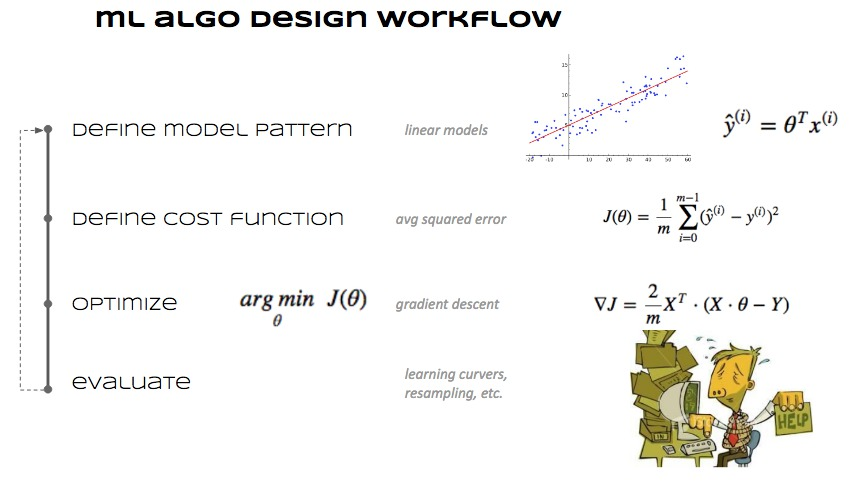

In [4]:
from IPython.display import Image
Image(filename='local/imgs/mldesign.jpg', width=800)

## And how we sorted it out for linear regression using a generic optimization library


**Input** and **expected output** (supervised learning)
- $\mathbf{x}^{(i)} \in \mathbb{R}^n$, $y^{(i)} \in \mathbb{R}$

**Predicción model** 

- $\hat{y}^{(i)} = \overline{\theta} \dot \;  \mathbf{x}^{(i)}$, $\;\;\;\;$with $\overline{\theta} \in \mathbb{R}^n$ and assuming $\mathbf{x}^{(i)}_0=1$

**Loss function**

- $J(\overline{\theta}) = \frac{1}{m} \sum_{i=0}^{m-1}(\overline{\theta} \dot \;  \mathbf{x}^{(i)} - y^{(i)})^2$


**Gradient of loss function** (matrix form)

- $\nabla J = \begin{bmatrix}
\frac{\partial J}{\partial \theta_0}\\
\frac{\partial J}{\partial \theta_1}
\end{bmatrix} = \frac{1}{m}2X^{T}\cdot(X\cdot\theta-Y)$


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

(150, 2)


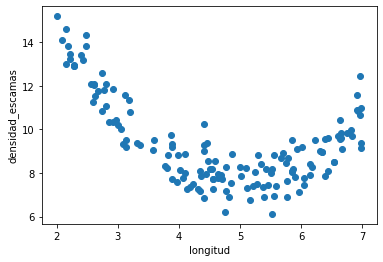

In [6]:
d = pd.read_csv("local/data/trilotropicos.csv")
print(d.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

In [7]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T


def n_cost(t):
    return np.mean((X.dot(t)-y)**2)

def n_grad(t):
    return 2*X.T.dot(X.dot(t)-y)/len(X)

init_t = np.random.random()*40-5, np.random.random()*20-10
r = minimize(n_cost, init_t, method="BFGS", jac=n_grad)
r

      fun: 2.7447662570806624
 hess_inv: array([[ 5.57455133, -1.09184708],
       [-1.09184708,  0.23443488]])
      jac: array([-1.43724881e-06, -7.18659553e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([12.68999789, -0.71805919])

## Using `sympy` computer algebra system (CAS)

In [8]:
x,y = sy.symbols("x y")

In [9]:
z = x**2 + x*sy.cos(y)
z

we can evaluate the expresion by providing concrete values for the symbolic variables

In [10]:
z.subs({x: 2, y: sy.pi/4})


and obtain numerical approximations of these values

In [11]:
sy.N(z.subs({x: 2, y: sy.pi/4}))

a **derivative** can be seen as a function that inputs and expression and outputs another expression

observe how we compute $\frac{\partial z}{\partial x}$ and $\frac{\partial z}{\partial y}$

In [12]:
z.diff(x)

In [13]:
z.diff(y)

In [14]:
r = z.diff(x).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

In [15]:
r = z.diff(y).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

**EXERCISE**: draw the computational graph of $x^2+x\cos(x)$ and show how to differentiate mechanically using the graphs.

More things you can do with `sympy` (and almost any CAS)

In [16]:
sy.expand((x+2)**2)

In [17]:
sy.factor( x**2-2*x-8 )

In [18]:
sy.solve( x**2 + 2*x - 8, x)

In [19]:
a = sy.symbols("alpha")
sy.solve( a*x**2 + 2*x - 8, x)


differential equations, solving $\frac{df}{dt}=f(t)+t$

In [20]:
t, C1 = sy.symbols("t C1")
f = sy.symbols("f", cls=sy.Function)
dydt = f(t)+t
eq = dydt-sy.diff(f(t),t)
yt = sy.dsolve(eq, f(t))
yt

 systems of equations

In [21]:
sy.solve ([x**2+y, 3*y-x])

## `Sympy` to `Python` and `Numpy`

See [Sympy Numeric Computation](http://docs.sympy.org/latest/modules/numeric-computation.html)


In [22]:
f = (sy.sin(x) + x**2)/2
f

In [23]:
f.subs({x:10})

In [24]:
sy.N(f.subs({x:10}))

In [25]:
f1 = sy.lambdify(x, f)
f1(10)

and a vectorized version

In [26]:
f2 = sy.lambdify(x, f, "numpy")

In [27]:
f2(10)

In [28]:
f2(np.array([10,2,3]))

array([49.72798944,  2.45464871,  4.57056   ])

the _lambdified_ version is faster, and the vectorized one is even faster

In [29]:
%timeit sy.N(f.subs({x:10}))

125 µs ± 8.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%timeit f1(10)

1.33 µs ± 26.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [31]:
%timeit [f1(i) for i in range(1000)]

1.38 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit f2(np.arange(1000))

17.6 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Using `sympy` to obtain the gradient.

In [33]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T

t0,t1 = sy.symbols("theta_0 theta_1")
t0,t1

we first obtain the cost expression for a few summation terms, so that we can print it out and understand it

In [34]:
expr = 0
for i in range(10):
    expr += (X[i,0]*t0+X[i,1]*t1-y[i])**2
expr = expr/len(X)
expr

find `X[0]` and `y[0]` in the expression above, beware that you might get simplifications and reordering of the expression by `sympy`

In [ ]:
y[:10]

we can now simplify the expression, using `sympy` mechanics

In [37]:
expr = expr.simplify()
expr

we now build the full expression

In [38]:
def build_logisitic_regression_cost_expression(X,y):
    expr_cost = 0
    for i in range(len(X)):
        expr_cost += (X[i,0]*t0+X[i,1]*t1-y[i])**2/len(X)
    expr_cost = expr_cost.simplify()
    return expr_cost

In [39]:
y = d.densidad_escamas.values
X = np.r_[[[1]*len(d), d.longitud.values]].T

expr_cost = build_logisitic_regression_cost_expression(X,y)
expr_cost

In [40]:
%timeit build_logisitic_regression_cost_expression(X,y)

2.6 s ± 68.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


obtain derivatives symbolically

In [41]:
expr_dt0 = expr_cost.diff(t0)
expr_dt1 = expr_cost.diff(t1)
expr_dt0, expr_dt1

and obtain regular Python so that we can use them in optimization 

In [42]:
s_cost = sy.lambdify([[t0,t1]], expr_cost, "numpy")

d0 = sy.lambdify([[t0,t1]], expr_dt0, "numpy")
d1 = sy.lambdify([[t0,t1]], expr_dt1, "numpy")
s_grad = lambda x: np.array([d0(x), d1(x)])

and now we can minimize

In [43]:
r = minimize(s_cost, [0,0], jac=s_grad, method="BFGS")
r

      fun: 2.7447662570799594
 hess_inv: array([[ 5.57425906, -1.09086733],
       [-1.09086733,  0.23434848]])
      jac: array([-1.73778293e-07, -9.26928138e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([12.6899981, -0.7180591])

observe that hand derived functions and the ones obtained by `sympy` evaluate to the same values

In [45]:
t0 = np.random.random()*5+10
t1 = np.random.random()*4-3
t = np.r_[t0,t1]

print ("theta:",t)
print ("cost analytic:", n_cost(t))
print ("cost symbolic:", s_cost(t))

print ("gradient analytic:", n_grad(t))
print ("gradient symbolic:", s_grad(t))

theta: [13.38981165 -1.04706873]
cost analytic: 3.664362725033482
cost symbolic: 3.6643627250332145
gradient analytic: [-1.66013083 -9.12123711]
gradient symbolic: [-1.66013083 -9.12123711]


## and we are still using black box optimization!!!!